In [1]:
import numpy as np
from sompy.sompy import SOMFactory
import pandas as pd
import glob
import os

CACHEDIR=/Users/juniorlima/.matplotlib
Using fontManager instance from /Users/juniorlima/.matplotlib/fontlist-v300.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}


Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [6]:
# read in all csvs from folder
path = "../../data/"
all_files = glob.glob(os.path.join(path, "*.csv"))

In [7]:
# concat into one df
df_from_each_file = (pd.read_csv(f, skiprows = 31) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [8]:
# get columns Lat, Long, Mean Temp, Max Temp, Min temp, Precipitation
data = concatenated_df[['Lat', 'Long', 'Tm', 'Tx', 'Tn', 'P']]
data = data.apply(pd.to_numeric,  errors='coerce')
data = data.dropna(how='any')
names = ['Latitude', "longitude", 'Monthly Median temperature (C)','Monthly Max temperature (C)', 'Monthly Min temperature (C)', 'Monthly total precipitation (mm)']

print(data.head())

      Lat     Long   Tm    Tx    Tn      P
0  48.935 -123.742  2.9  10.5  -5.0  104.8
1  48.824 -124.133 -1.7   3.0  -6.0    0.0
2  48.829 -124.052 -0.3  10.0 -12.5  198.2
4  48.432 -123.439  3.9  10.4  -3.3   37.8
5  48.985 -123.573  3.4  11.0  -4.0   77.2


In [23]:
# create the SOM network and train it. You can experiment with different normalizations and initializations
sm = SOMFactory().build(data.values, normalization = 'var', initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=2, train_finetune_len=5)

maxtrainlen %d inf
maxtrainlen %d inf


In [10]:
# The quantization error: average distance between each data vector and its BMU.
# The topographic error: the proportion of all data vectors for which first and second BMUs are not adjacent units.
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.08204911417701087; Quantization error = 0.5591334189558946


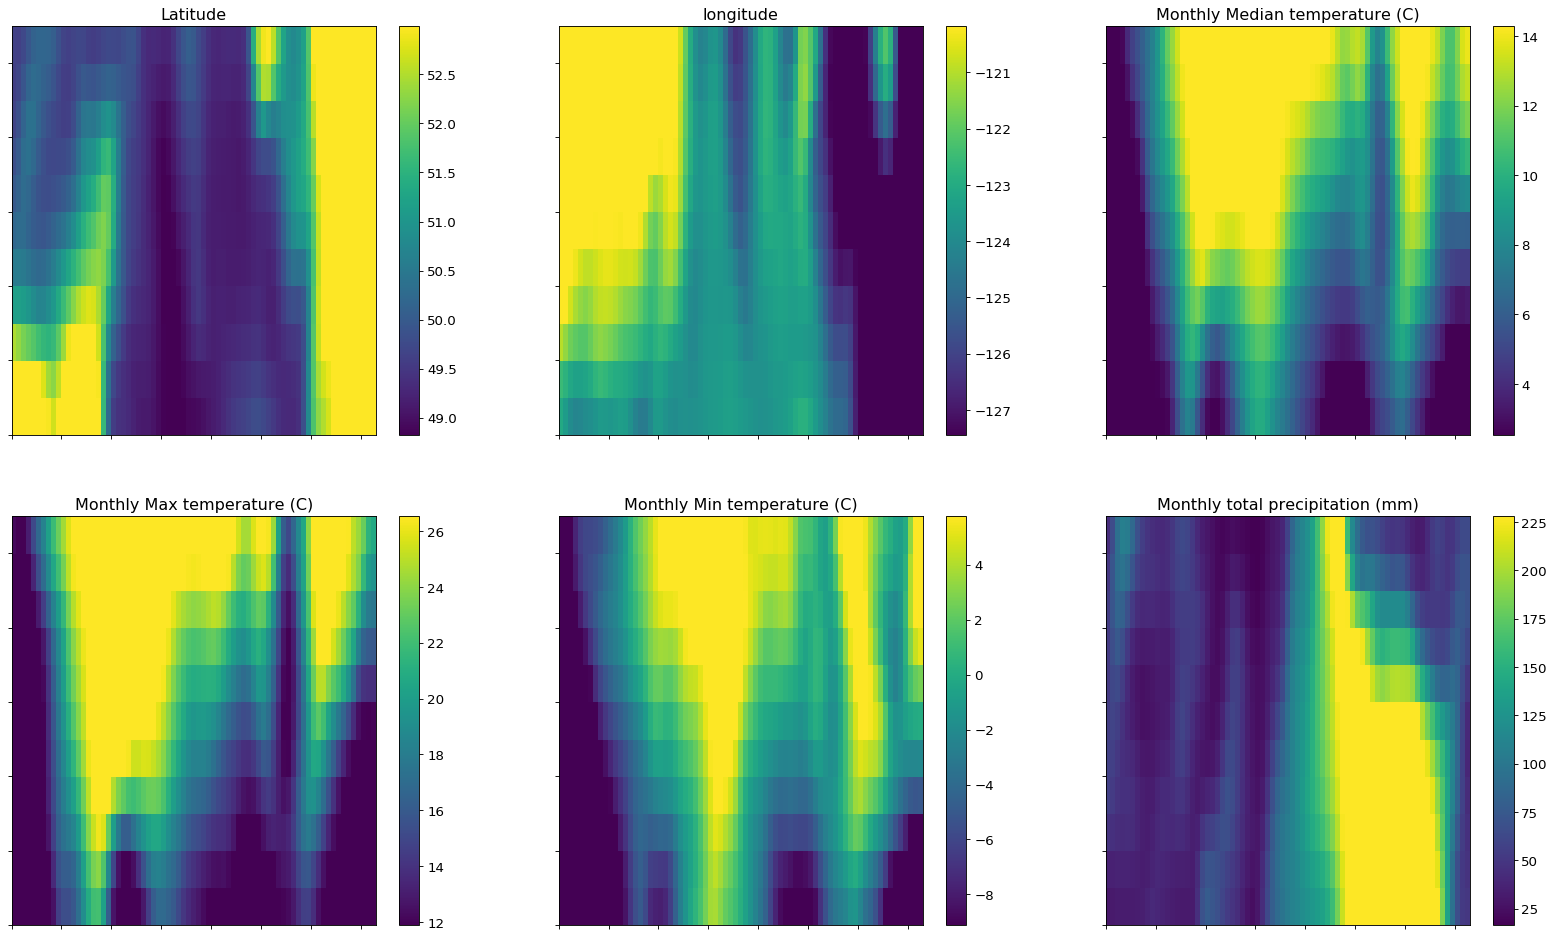

In [11]:
# component planes view
from sompy.visualization.mapview import View2D
view2D  = View2D(width=10,height=10,title="rand data",text_size=12)
import matplotlib as mpl
view2D.show(sm, col_sz=3, which_dim="all", desnormalize=True)

import matplotlib.pylab as plt
fig = plt.gcf()
fig.set_size_inches(25,23)

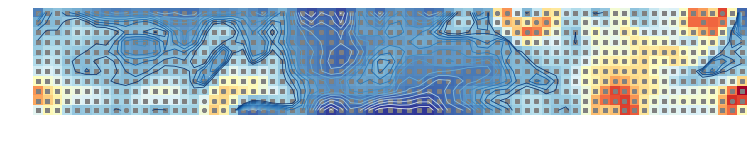

In [12]:
# U-matrix plot
from sompy.visualization.umatrix import UMatrixView

umat  = UMatrixView(width=10,height=10,title='U-matrix')
umat.show(sm)

import matplotlib.pylab as plt

In [14]:
def cluster(self, n_clusters=8, opt = 0):
        import sklearn.cluster as clust

        print("Performing K-means SSE elbow sweep...")

        # generate the bootstrap samples
        BTS = 20
        BTS_SIZE = 0.8

        normalized_data = self._normalizer.denormalize_by(self.data_raw,
                                                          self.codebook.matrix)

        if(opt == 0):
            bts_len = int(BTS_SIZE * len(normalized_data))
            bootstrap_samples = []
            for i in range(BTS):

                temp = []
                for j in range(bts_len):
                    index = np.random.randint(0,len(normalized_data))
                    temp.append(normalized_data[index])
                temp = np.array(temp)
                bootstrap_samples.append(temp)

            SSE_BTS_K = []
            for i in range(2,n_clusters+1):

                SSE_K = []
                for l in range(BTS):
                    print("Working on bootstrap sample " + str(l) + " K: " + str(i))
                    km = clust.KMeans(n_clusters=i).fit(bootstrap_samples[l])
                    SSE = 0
                    # calculate the Sum of Square Errors and compute the elbow point
                    for k in bootstrap_samples[l]:
                        label = km.predict([k])[0]
                        SSE = SSE + np.linalg.norm(k - km.cluster_centers_[label])
                    SSE_K.append(SSE)
                # average the bootstrapped SSE's
                SSE_BTS_K.append(np.sum(SSE_K) / float(BTS))



            # find the index of the maximum value of the 1st difference and add 1 to get the optimal K
            first_diff = np.diff(SSE_BTS_K)
            print("SSE for k = 2 to " + str(n_clusters) + " " + str(SSE_BTS_K))
            index = np.argmax(first_diff) + 1

            print("Optimal K = " + str(index))

        else:
            index = opt


        km = clust.KMeans(n_clusters=index).fit(normalized_data)

        # print cluster centroids
        for i in range(index):
            print("Centroid " + str(i) + str(km.cluster_centers_[i]))

        self.cluster_labels = km.labels_
        return km.labels_, km, normalized_data

Performing K-means SSE elbow sweep...
Centroid 0[  51.22833829 -124.8558426     7.74050846   16.73096733   -0.77162474
   91.32841142]
Centroid 1[  50.40670493 -125.5761164     6.34796725   14.75049244   -1.8625378
  293.12787118]
Centroid 2[  50.51099141 -126.49750896    6.89480902   14.84388484   -1.11167982
  576.79955471]
Centroid 3[  50.53046706 -125.42598653    7.92190914   16.80654834   -0.32197216
  199.82619345]
Centroid 4[  51.26400756 -121.69982501    6.04993658   18.47267138   -5.60132786
   35.96272998]
Centroid 5[  50.2960522  -126.24022499    6.73331897   14.43395857   -1.20455307
  472.26222924]
Centroid 6[  50.3697783  -125.18033755    9.73495685   19.02940415    1.5735563
  114.4393249 ]
Centroid 7[  51.45844154 -122.2189871    12.72372258   26.21007806    1.42989217
   50.51357581]
Centroid 8[  50.48472202 -125.32825504    6.99807687   15.75735129   -1.48685982
  230.20224019]
Centroid 9[  50.57565365 -126.42309061    6.8144569    14.63937415   -1.06636253
  397.8957

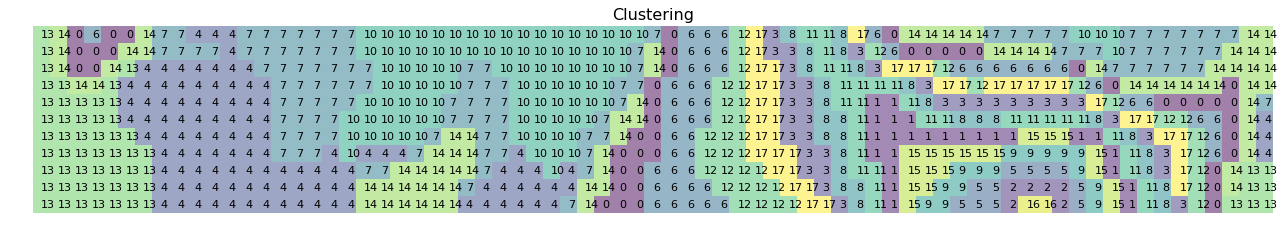

In [15]:
# do the K-means clustering on the SOM grid, sweep across k = 2 to 20
from sompy.visualization.hitmap import HitMapView
K = 20 # stop at this k for SSE sweep
K_opt = 18 # optimal K already found
[labels, km, norm_data] = cluster(sm, K, K_opt)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(sm)

In [19]:
import gmplot

gmap = gmplot.GoogleMapPlotter(54.2, -124.875224, 6)
j = 0
for i in km.cluster_centers_:
    gmap.marker(i[0],i[1],'red', title="Centroid " + str(j))
    j += 1

gmap.draw("centroids_map.html")